In [2]:
import sys
import os, glob
import time
from pathlib import Path

import awkward
import awkward as ak
import mplhep
import numpy as np
import pandas as pd

import torch
import tqdm
import vector
import boost_histogram as bh

import itertools
import matplotlib.pyplot as plt

import mplhep

mplhep.set_style(mplhep.styles.CMS)

sys.path.append("../mlpf/plotting/")

import plot_utils
from plot_utils import pid_to_text, load_eval_data, compute_jet_ratio

from plot_utils import CLASS_LABELS_CLIC, CLASS_NAMES_CLIC

In [3]:
%load_ext autoreload
%autoreload 2

In [1120]:
def med_iqr(arr):
    p25 = np.percentile(arr, 25)
    p50 = np.percentile(arr, 50)
    p75 = np.percentile(arr, 75)
    return p50, p75 - p25


def flatten(arr):
    return arr.reshape(-1, arr.shape[-1])


def binom_error(n_sig, n_tot):
    """
    for an efficiency = nSig/nTrueSig or purity = nSig / (nSig + nBckgrd), this function calculates the
    standard deviation according to http://arxiv.org/abs/physics/0701199 .
    """
    variance = np.where(
        n_tot > 0, (n_sig + 1) * (n_sig + 2) / ((n_tot + 2) * (n_tot + 3)) - (n_sig + 1) ** 2 / ((n_tot + 2) ** 2), 0
    )
    return np.sqrt(variance)


def plot_eff_and_fake_rate(icls=1, ivar=4, ielem=1, bins=np.linspace(-3, 6, 100), 
                           log=True,
                           physics_process_lab="",
                           textx=0.01,
                           texty=0.87,
                          ):

    xlabel = elemlabel[ielem][ivar]
    
    values = X[:, :, ivar]

    hist_X = bh.Histogram(bh.axis.Variable(bins))
    hist_gen = bh.Histogram(bh.axis.Variable(bins))
    hist_gen_pred = bh.Histogram(bh.axis.Variable(bins))
    hist_gen_cand = bh.Histogram(bh.axis.Variable(bins))
    hist_pred = bh.Histogram(bh.axis.Variable(bins))
    hist_cand = bh.Histogram(bh.axis.Variable(bins))
    hist_pred_fake = bh.Histogram(bh.axis.Variable(bins))
    hist_cand_fake = bh.Histogram(bh.axis.Variable(bins))

    eff_mlpf = bh.Histogram(bh.axis.Variable(bins), storage=bh.storage.Weight())
    eff_pf = bh.Histogram(bh.axis.Variable(bins), storage=bh.storage.Weight())
    fake_pf = bh.Histogram(bh.axis.Variable(bins), storage=bh.storage.Weight())
    fake_mlpf = bh.Histogram(bh.axis.Variable(bins), storage=bh.storage.Weight())

    if ielem == 45:   # ECAL and HCAL in CMS
        msk_X = (X[:, :, 0] == 4) | (X[:, :, 0] == 5)
    else:
        msk_X = X[:, :, 0] == ielem

    msk_gen = yvals["gen_cls_id"] == icls
    msk_nogen = yvals["gen_cls_id"] != icls
        
    msk_pred = yvals["pred_cls_id"] == icls
    msk_nopred = yvals["pred_cls_id"] != icls

    msk_cand = yvals["cand_cls_id"] == icls
    msk_nocand = yvals["cand_cls_id"] != icls

    hist_X.fill(awkward.flatten(values[msk_X]))
    hist_gen.fill(awkward.flatten(values[msk_gen & msk_X]))
    hist_pred.fill(awkward.flatten(values[msk_pred & msk_X]))
    hist_cand.fill(awkward.flatten(values[msk_cand & msk_X]))

    # Genparticle exists, reco particle exists
    hist_gen_pred.fill(awkward.flatten(values[msk_gen & msk_pred & msk_X]))
    hist_gen_cand.fill(awkward.flatten(values[msk_gen & msk_cand & msk_X]))        

    # Genparticle does not exist, reco particle exists
    hist_pred_fake.fill(awkward.flatten(values[msk_nogen & msk_pred & msk_X]))
    hist_cand_fake.fill(awkward.flatten(values[msk_nogen & msk_cand & msk_X]))

    eff_mlpf.values()[:] = hist_gen_pred.values() / hist_gen.values()
    eff_mlpf.variances()[:] = binom_error(hist_gen_pred.values(), hist_gen.values()) ** 2

    eff_pf.values()[:] = hist_gen_cand.values() / hist_gen.values()
    eff_pf.variances()[:] = binom_error(hist_gen_cand.values(), hist_gen.values()) ** 2

    fake_pf.values()[:] = hist_cand_fake.values() / hist_cand.values()
    fake_pf.variances()[:] = binom_error(hist_cand_fake.values(), hist_cand.values()) ** 2

    fake_mlpf.values()[:] = hist_pred_fake.values() / hist_pred.values()
    fake_mlpf.variances()[:] = binom_error(hist_pred_fake.values(), hist_pred.values()) ** 2

#     plt.figure()
#     ax = plt.axes()
#     mplhep.histplot(hist_X, label="all PFElements", color="black")
#     mplhep.histplot(hist_cand, label="with PF")
#     mplhep.histplot(hist_pred, label="with MLPF reco")
#     mplhep.histplot(hist_gen, label="with MLPF truth")
#     plt.ylabel("Number of PFElements / bin")
#     plt.xlabel(xlabel)
#     plt.yscale("log")

#     text = physics_process_lab + " , " + CLASS_NAMES_CLIC[icls]
#     plt.text(textx, texty+0.05, text, ha="left", transform=ax.transAxes)

#     if log:
#         plt.xscale("log")
#     plt.legend(loc=(0.6, 0.65))
#     plt.ylim(10, 20 * np.max(hist_X.values()))
#     plt.xlim(min(bins), max(bins))
#     plt.savefig(f"{outpath}/distr_icls{icls}_ivar{ivar}.pdf", bbox_inches="tight")

    plt.figure()
    ax = plt.axes()
    mplhep.histplot(eff_pf, label="PF")
    mplhep.histplot(eff_mlpf, label="MLPF")
    plt.ylim(0, 1.5)
    plt.ylabel("Efficiency")
    plt.xlabel(xlabel)

    text = physics_process_lab + " , " + CLASS_NAMES_CLIC[icls]
    plt.text(textx, texty, text, ha="left", transform=ax.transAxes)
    
    if log:
        plt.xscale("log")
    plt.legend(loc=(0.75, 0.7))
    plt.xlim(min(bins), max(bins))
    plt.savefig(f"{outpath}/eff_icls{icls}_ivar{ivar}.pdf", bbox_inches="tight")

    plt.figure()
    ax = plt.axes(sharex=ax)
    mplhep.histplot(fake_pf, label="PF")
    mplhep.histplot(fake_mlpf, label="MLPF")
    plt.ylim(0, 1.5)
    plt.ylabel("Fake rate")
    plt.xlabel(xlabel)
    
    text = physics_process_lab + " , " + CLASS_NAMES_CLIC[icls]
    plt.text(textx, texty, text, ha="left", transform=ax.transAxes)
    
    if log:
        plt.xscale("log")
    plt.legend(loc=(0.75, 0.7))
    plt.xlim(min(bins), max(bins))
    plt.savefig(f"{outpath}/fake_icls{icls}_ivar{ivar}.pdf", bbox_inches="tight")

    # mplhep.histplot(fake, bins=hist_gen[1], label="fake rate", color="red")


#     plt.legend(frameon=False)
#     plt.ylim(0,1.4)
#     plt.xlabel(xlabel)
#     plt.ylabel("Fraction of particles / bin")

In [1007]:
! ls evaluation/epoch_96

clic_edm_qq_pf            clic_edm_single_pi_pf     clic_edm_ww_fullhad_pf
clic_edm_single_gamma_pf  clic_edm_ttbar_pf         clic_edm_zh_tautau_pf
clic_edm_single_kaon0l_pf clic_edm_ttbar_pu10_pf


In [1008]:
sample = "clic_edm_ttbar_pf"

PATH = "evaluation/epoch_96"

pred_path = Path(f"{PATH}/{sample}/test/")
path = str(pred_path / "*.parquet")

outpath = f"paper_plots/{sample}"   # plots path
os.system(f"mkdir -p {outpath}");

In [1009]:
! ls evaluation/epoch_96/clic_edm_ttbar_pf/test/*.parquet | wc -l

    4004


# Load the predictions

In [1278]:
yvals, X, _ = load_eval_data(path, max_files=200)

path evaluation/epoch_96/clic_edm_ttbar_pf/test/*.parquet
['evaluation/epoch_96/clic_edm_ttbar_pf/test/pred_batch3708.parquet', 'evaluation/epoch_96/clic_edm_ttbar_pf/test/pred_batch2202.parquet', 'evaluation/epoch_96/clic_edm_ttbar_pf/test/pred_batch175.parquet', 'evaluation/epoch_96/clic_edm_ttbar_pf/test/pred_batch1168.parquet', 'evaluation/epoch_96/clic_edm_ttbar_pf/test/pred_batch3670.parquet', 'evaluation/epoch_96/clic_edm_ttbar_pf/test/pred_batch994.parquet', 'evaluation/epoch_96/clic_edm_ttbar_pf/test/pred_batch1989.parquet', 'evaluation/epoch_96/clic_edm_ttbar_pf/test/pred_batch1010.parquet', 'evaluation/epoch_96/clic_edm_ttbar_pf/test/pred_batch165.parquet', 'evaluation/epoch_96/clic_edm_ttbar_pf/test/pred_batch1178.parquet', 'evaluation/epoch_96/clic_edm_ttbar_pf/test/pred_batch3718.parquet', 'evaluation/epoch_96/clic_edm_ttbar_pf/test/pred_batch2212.parquet', 'evaluation/epoch_96/clic_edm_ttbar_pf/test/pred_batch1000.parquet', 'evaluation/epoch_96/clic_edm_ttbar_pf/test/pre

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:13<00:00, 15.13it/s]


# Make plots

In [1112]:
physics_process = {
    "clic_edm_ttbar_pf": r"$e^+e^- \rightarrow \mathrm{t}\overline{\mathrm{t}}$",
    "clic_edm_ttbar_pu10_pf": r"$e^+e^- \rightarrow \mathrm{t}\overline{\mathrm{t}}$, PU10",
    "clic_edm_qq_pf": r"$e^+e^- \rightarrow \gamma/\mathrm{Z}^* \rightarrow \mathrm{hadrons}$",
    "clic_edm_ww_fullhad_pf": r"$e^+e^- \rightarrow WW \rightarrow \mathrm{hadrons}$",
    "clic_edm_zh_tautau_pf": r"$e^+e^- \rightarrow ZH \rightarrow \tau \tau$",   
}

elemlabel = {
    1: ["N/A", r"track $p_T$", r"$\eta$", "sin_phi", "cos_phi", "Total p"],
    2: ["N/A", r"$E_T$", r"$\eta$", "sin_phi", "cos_phi", "cluster E [GeV]"],
}

# just a reminder
CLASS_NAMES_CLIC = [
    r"none",
    r"charged hadrons",
    r"neutral hadrons",
    r"$\gamma$",
    r"$e^\pm$",
    r"$\mu^\pm$",
]

In [1272]:
def med_iqr(arr):
    p25 = np.percentile(arr, 25)
    p50 = np.percentile(arr, 50)
    p75 = np.percentile(arr, 75)
    return p50, p75 - p25


def flatten(arr):
    return arr.reshape(-1, arr.shape[-1])


def binom_error(n_sig, n_tot):
    """
    for an efficiency = nSig/nTrueSig or purity = nSig / (nSig + nBckgrd), this function calculates the
    standard deviation according to http://arxiv.org/abs/physics/0701199 .
    """
    variance = np.where(
        n_tot > 0, (n_sig + 1) * (n_sig + 2) / ((n_tot + 2) * (n_tot + 3)) - (n_sig + 1) ** 2 / ((n_tot + 2) ** 2), 0
    )
    return np.sqrt(variance)


def plot_eff_isolation(icls=1, ivar=4, ielem=1, bins=np.linspace(-3, 6, 100), 
                           log=True,
                           physics_process_lab="",
                           textx=0.01,
                           texty=0.87,
                           apply_isolation="Isolated",
                          ):

    xlabel = elemlabel[ielem][ivar]
    
    values = X[:, :, ivar]

    hist_X = bh.Histogram(bh.axis.Variable(bins))
    hist_gen = bh.Histogram(bh.axis.Variable(bins))
    hist_gen_pred = bh.Histogram(bh.axis.Variable(bins))
    hist_gen_cand = bh.Histogram(bh.axis.Variable(bins))
    hist_pred = bh.Histogram(bh.axis.Variable(bins))
    hist_cand = bh.Histogram(bh.axis.Variable(bins))

    eff_mlpf = bh.Histogram(bh.axis.Variable(bins), storage=bh.storage.Weight())
    eff_pf = bh.Histogram(bh.axis.Variable(bins), storage=bh.storage.Weight())

    xlabel = elemlabel[ielem][ivar]
    
    values = X[:, :, ivar]

    hist_X = bh.Histogram(bh.axis.Variable(bins))
    hist_gen = bh.Histogram(bh.axis.Variable(bins))
    hist_gen_pred = bh.Histogram(bh.axis.Variable(bins))
    hist_gen_cand = bh.Histogram(bh.axis.Variable(bins))
    hist_pred = bh.Histogram(bh.axis.Variable(bins))
    hist_cand = bh.Histogram(bh.axis.Variable(bins))

    eff_mlpf = bh.Histogram(bh.axis.Variable(bins), storage=bh.storage.Weight())
    eff_pf = bh.Histogram(bh.axis.Variable(bins), storage=bh.storage.Weight())

    msk_X = (X[:, :, 0] == ielem)    
    msk_gen = (yvals["gen_cls_id"] == icls)        
    msk_pred = (yvals["pred_cls_id"] == icls)
    msk_cand = (yvals["cand_cls_id"] == icls)

    if apply_isolation == "Isolated":
        msk_iso = get_isolation(msk_gen)<0.15
    else:
        msk_iso = get_isolation(msk_gen)>0.15
    
    hist_X.fill(awkward.flatten(values[msk_X & msk_gen][msk_iso]))    
    hist_gen.fill(awkward.flatten(values[msk_X & msk_gen][msk_iso]))
        
    if apply_isolation == "Isolated":
        msk_iso = get_isolation(msk_gen & msk_pred)<0.15
    else:
        msk_iso = get_isolation(msk_gen & msk_pred)>0.15
        
    # Genparticle exists, reco particle exists
    hist_gen_pred.fill(awkward.flatten(values[msk_X & msk_gen & msk_pred][msk_iso]))
    
    if apply_isolation == "Isolated":
        msk_iso = get_isolation(msk_gen & msk_cand)<0.15
    else:
        msk_iso = get_isolation(msk_gen & msk_cand)>0.15    
    hist_gen_cand.fill(awkward.flatten(values[msk_X & msk_gen & msk_cand][msk_iso]))
    
    eff_mlpf.values()[:] = hist_gen_pred.values() / hist_gen.values()
    eff_mlpf.variances()[:] = binom_error(hist_gen_pred.values(), hist_gen.values()) ** 2

    eff_pf.values()[:] = hist_gen_cand.values() / hist_gen.values()
    eff_pf.variances()[:] = binom_error(hist_gen_cand.values(), hist_gen.values()) ** 2
    
    plt.figure()
    ax = plt.axes()
    mplhep.histplot(eff_pf, label="PF")
    mplhep.histplot(eff_mlpf, label="MLPF")
    plt.ylim(0, 1.5)
    plt.ylabel("Efficiency")
    plt.xlabel(xlabel)

    text = physics_process_lab + " , " + CLASS_NAMES_CLIC[icls]
    if apply_isolation:
        text = physics_process_lab + " , " + apply_isolation + " " + CLASS_NAMES_CLIC[icls]
    
    plt.text(textx, texty, text, ha="left", transform=ax.transAxes)
    
    if log:
        plt.xscale("log")
    plt.legend(loc=(0.75, 0.7))
    plt.xlim(min(bins), max(bins))
    plt.savefig(f"{outpath}/{apply_isolation}_eff_icls{icls}_ivar{ivar}.pdf", bbox_inches="tight")

    # mplhep.histplot(fake, bins=hist_gen[1], label="fake rate", color="red")


#     plt.legend(frameon=False)
#     plt.ylim(0,1.4)
#     plt.xlabel(xlabel)
#     plt.ylabel("Fraction of particles / bin")

In [1279]:
# import awkward as ak

# # Example: Two leptons in the first event, first one not isolated, second one is isolated
# # No lepton in second event, but still some other particles
# # Third event has a good lepton with a stray hadron/photon/... around it
# leptons = ak.Array([[10., 20.], [], [30.]])
# others = ak.Array([[1., 2., 3.], [4., 5.], [1.5]])
# dR = ak.Array([[[0.25, 0.3, 0.35], [0.6, 0.7, 0.8]],
#                [],
#                [[0.2]]])

# cartesian_product = ak.cartesian({"leptons": leptons, "others": others}, nested=True) # Create a nested Cartesian product of leptons and others
# dR_mask = ak.any(dR < 0.3, axis=-1) # Use ak.any to construct the dR mask
# events_extended = ak.mask(cartesian_product, dR_mask) # Apply the mask to the Cartesian product
# isolation_sum = ak.fill_none(ak.sum(events_extended.others, axis=-1), 0) # Fill None values with 0 after the sum (if no other particle nearby)
# rel_iso = isolation_sum / leptons
# print(rel_iso) # [[0.6, 0], [], [0.1]]

def get_isolation(msk=yvals["gen_cls_id"]==4):
    
    import numpy as np
    import awkward as ak
    from coffea.nanoevents.methods import vector    
    
    typ = "gen"

    gen_array = {}
    gen_array["cls"] = yvals[f"{typ}_cls"]
    gen_array["charge"] = yvals[f"{typ}_charge"]
    gen_array["pt"] = yvals[f"{typ}_pt"]
    gen_array["eta"] = yvals[f"{typ}_eta"]
    gen_array["sin_phi"] = yvals[f"{typ}_sin_phi"]
    gen_array["cos_phi"] = yvals[f"{typ}_cos_phi"]
    # gen_array["phi"] =  np.arctan2(yvals[f"{typ}_sin_phi"], yvals[f"{typ}_cos_phi"])
    gen_array["cls_id"] = yvals[f"{typ}_cls_id"]

    gen_array["px"] = gen_array["pt"] * gen_array["cos_phi"]
    gen_array["py"] = gen_array["pt"] * gen_array["sin_phi"]
    gen_array["pz"] = gen_array["pt"] * np.sinh(gen_array["eta"])

    gen_array = ak.zip(gen_array, depth_limit=1)

    # define particle selections
    indices_chhadrons = gen_array.cls_id == 1
    indices_nhadrons = gen_array.cls_id == 2
    indices_photons = gen_array.cls_id == 3
    
    particle_in_question = ak.zip(
        {
            "x": gen_array.px[msk],
            "y": gen_array.py[msk],
            "z": gen_array.pz[msk],
        },
        with_name="LorentzVector",
        behavior=vector.behavior,
    )
    others = ak.zip(
        {
            "x": gen_array.px[indices_chhadrons | indices_nhadrons | indices_photons],
            "y": gen_array.py[indices_chhadrons | indices_nhadrons | indices_photons],
            "z": gen_array.pz[indices_chhadrons | indices_nhadrons | indices_photons],
        },
        with_name="LorentzVector",
        behavior=vector.behavior,
    )

    mval = particle_in_question.metric_table(others)
    
#     mval.type    # 5000 * NLeptons * NHadrons
#     others.type    # 5000 * NHadrons    
#     particle_in_question.type    # 5000 * NLeptons

    dR_threshold = 0.3

    isolation = [] # initialize
    counts = []

    for iev in range(len(particle_in_question)):
        counts.append(0)
        for iprtkl, prtkl in enumerate(particle_in_question[iev]):
            counts[iev] += 1        

            mask = (mval<dR_threshold)[iev][iprtkl]

            isolation.append((1/prtkl.pt) * ak.sum(others[iev][mask].pt))

    #     if iev == 100:
    #         break

    iso = ak.unflatten(isolation, counts)
    
#     # pick firsts    
#     iso = iso[ak.argsort(leptons.pt, ascending=False)]
#     iso = ak.firsts(iso)

    # pick all
#     iso = ak.flatten(iso)    
    
    return iso

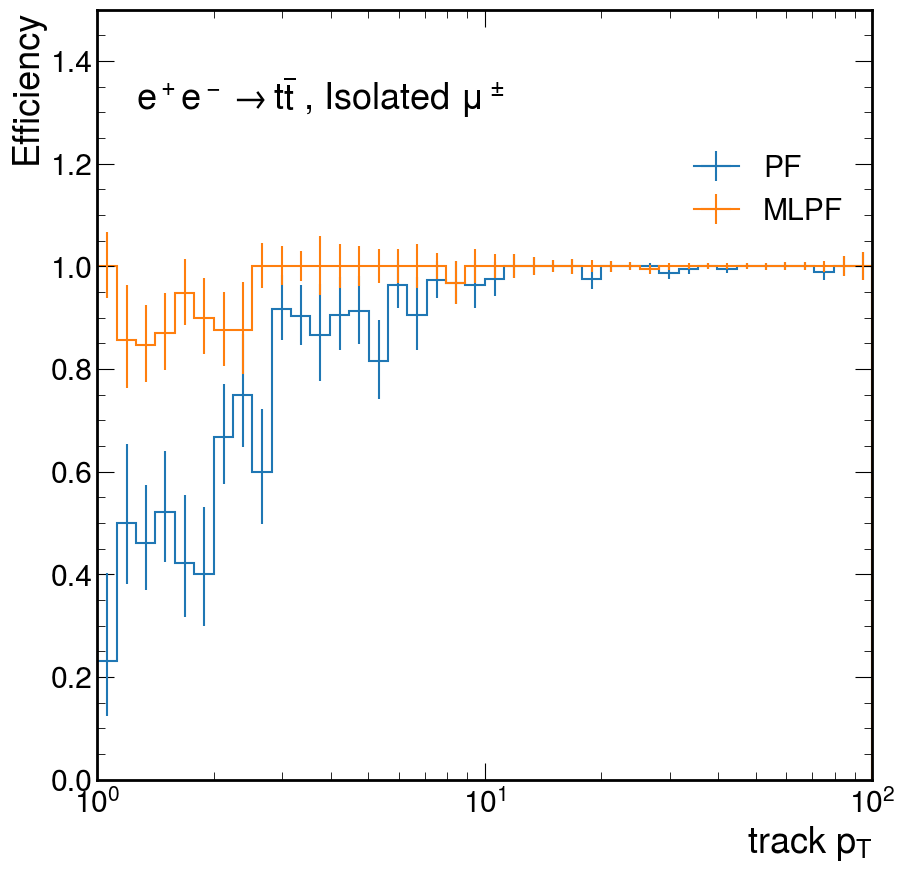

In [1282]:
var = 1
log_ = True

if log_:
    bins = np.logspace(0, 2, 41)
else:
    bins = np.linspace(1, 100, 41)

plot_eff_isolation(icls=5, ivar=var, ielem=ielem, bins=bins,
                       log=log_, 
                       physics_process_lab=physics_process[sample],
                       textx=0.05,
                       texty=0.87,
                       apply_isolation="Isolated",
                      )

/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_88631/3821530621.py:86: RuntimeWarning: invalid value encountered in divide
  eff_mlpf.values()[:] = hist_gen_pred.values() / hist_gen.values()
/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_88631/3821530621.py:89: RuntimeWarning: invalid value encountered in divide
  eff_pf.values()[:] = hist_gen_cand.values() / hist_gen.values()


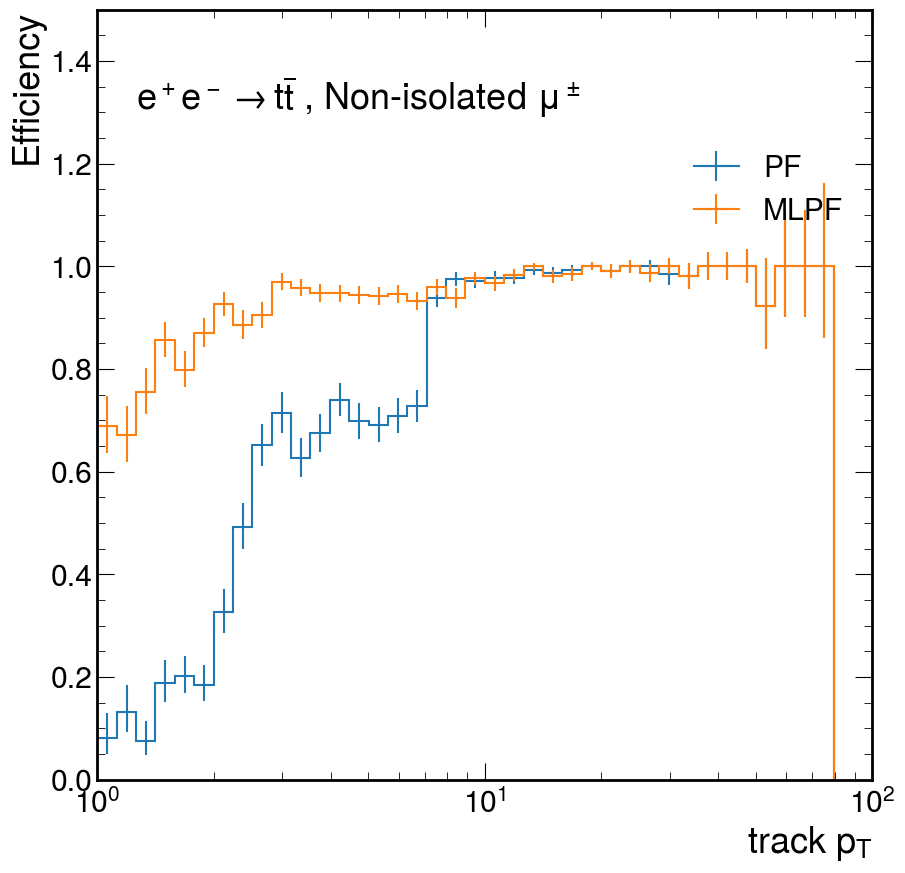

In [1283]:
var = 1
log_ = True

if log_:
    bins = np.logspace(0, 2, 41)
else:
    bins = np.linspace(1, 100, 41)

plot_eff_isolation(icls=5, ivar=var, ielem=ielem, bins=bins,
                       log=log_, 
                       physics_process_lab=physics_process[sample],
                       textx=0.05,
                       texty=0.87,
                       apply_isolation="Non-isolated",
                      )

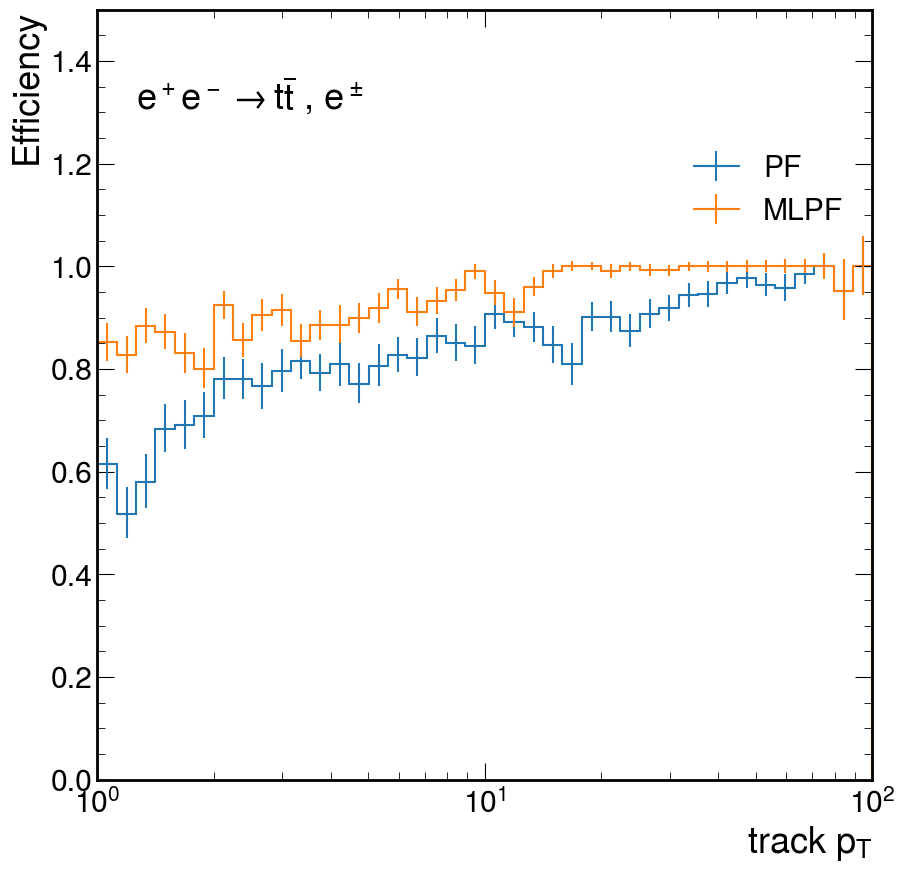

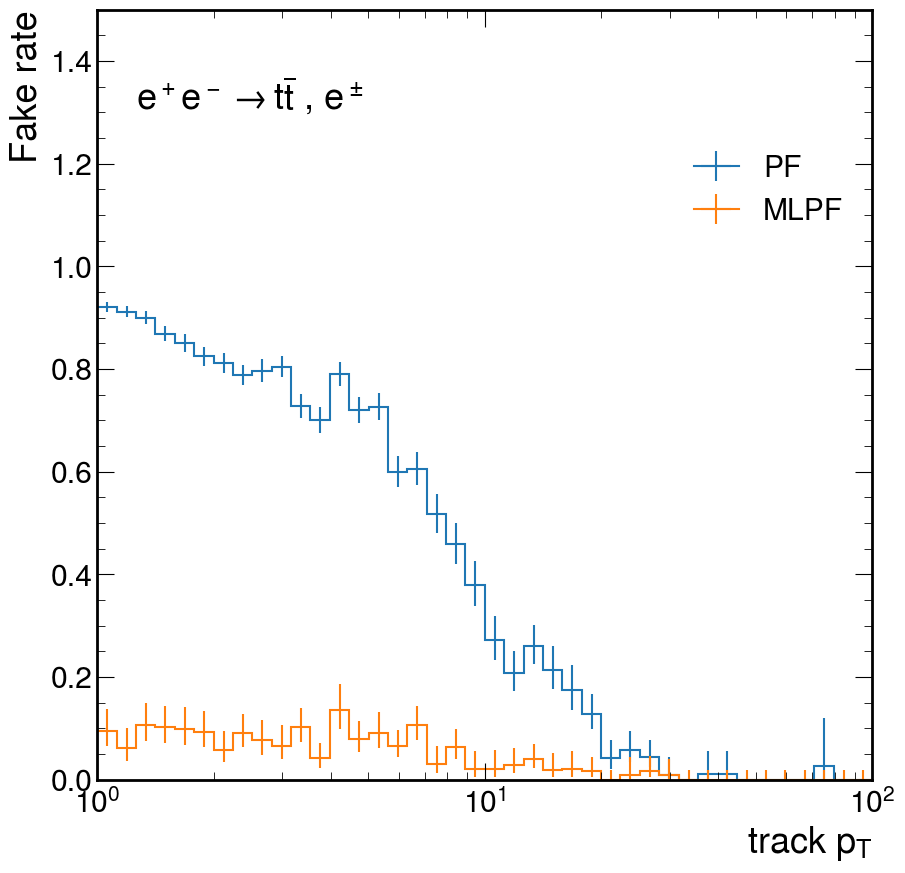

In [1232]:
var = 1
log_ = True

if log_:
    bins = np.logspace(0, 2, 41)
else:
    bins = np.linspace(1, 100, 41)

plot_eff_and_fake_rate(icls=4, ivar=var, ielem=ielem, bins=bins,
                       log=log_, 
                       physics_process_lab=physics_process[sample],
                       textx=0.05,
                       texty=0.87,
                      )

## c.hadrons

In [1070]:
pid = 4
ielem = 1 # must plot tracks

In [1071]:
var = 1
log_ = True

if log_:
    bins = np.logspace(0, 2, 41)
else:
    bins = np.linspace(1, 100, 41)

plot_eff_and_fake_rate(icls=pid, ivar=var, ielem=ielem, bins=bins,
                       log=log_, 
                       physics_process_lab=physics_process[sample],
                       textx=0.05,
                       texty=0.87,
                       apply_isolation="isolated",
                      )

ValueError: in ListArray64 attempting to get 1, index out of range

(https://github.com/scikit-hep/awkward-1.0/blob/1.10.3/src/cpu-kernels/awkward_ListArray_getitem_jagged_apply.cpp#L43)

In [1074]:
msk_gen

<Array [[False, False, ... False, False]] type='250 * var * bool'>

In [1075]:
msk_pred

<Array [[False, False, ... False, False]] type='250 * var * bool'>

In [1076]:
msk_X

<Array [[True, True, True, ... False, False]] type='250 * var * bool'>

In [1078]:
values[msk_gen & msk_pred][msk_iso]

ValueError: in ListArray64 attempting to get 1, index out of range

(https://github.com/scikit-hep/awkward-1.0/blob/1.10.3/src/cpu-kernels/awkward_ListArray_getitem_jagged_apply.cpp#L43)

## n.hadrons

In [17]:
pid = 2
ielem = 2 # must plot clusters

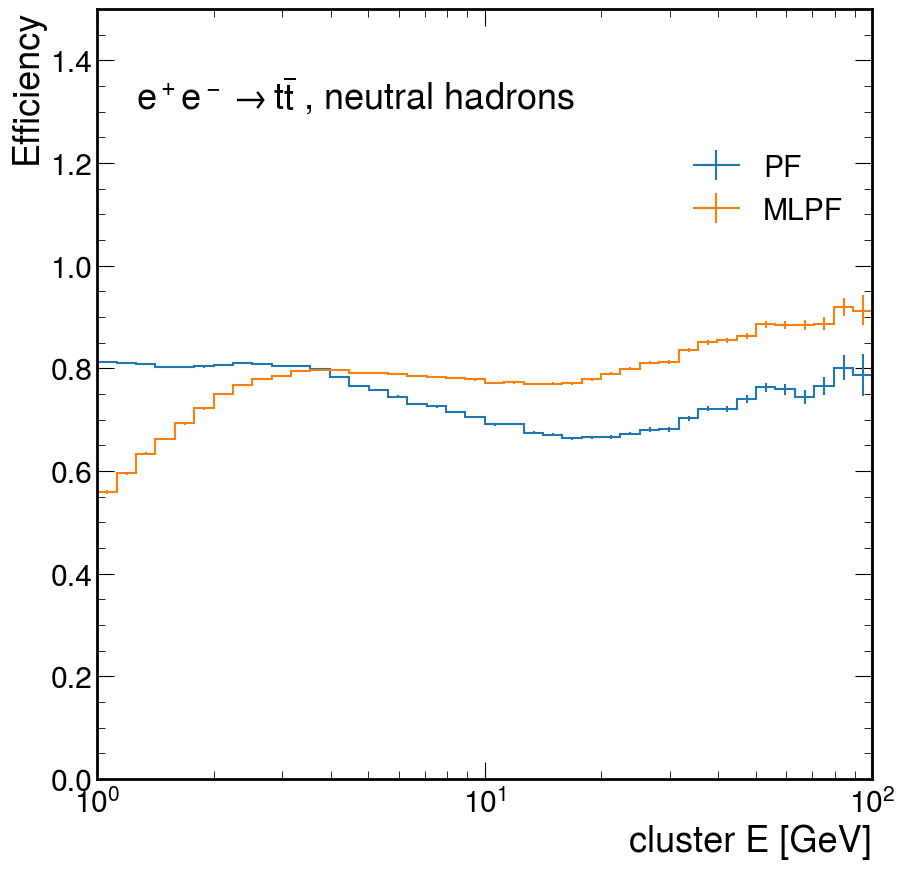

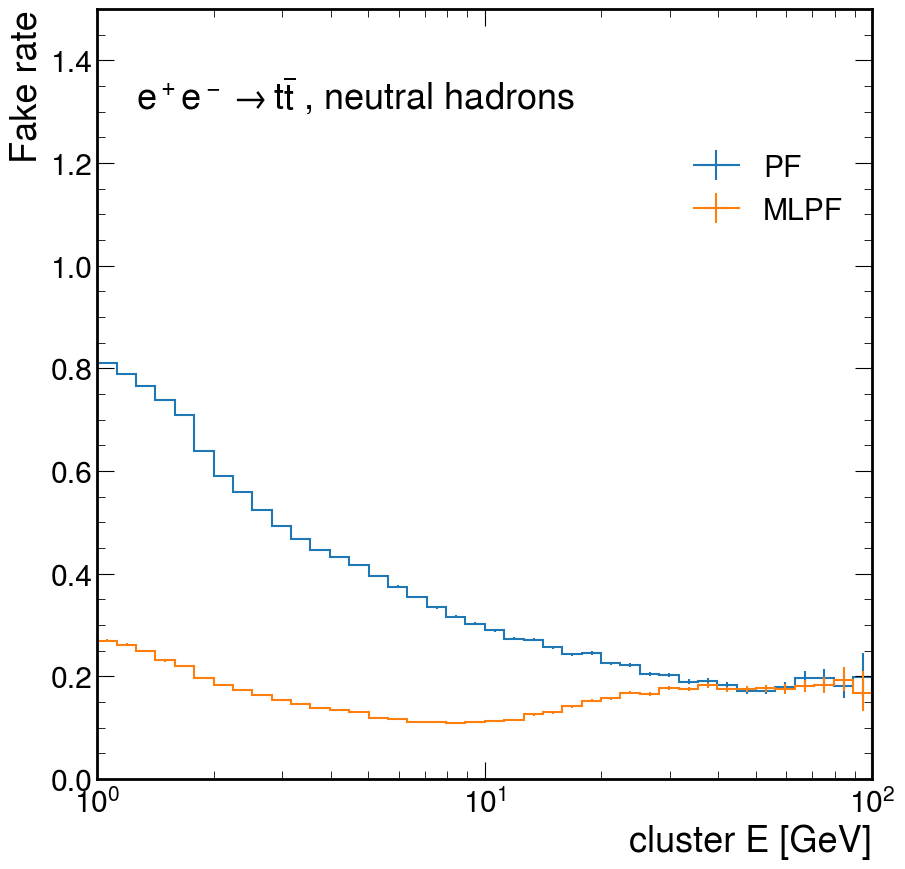

In [18]:
var = 5
log_ = True

if log_:
    bins = np.logspace(0, 2, 41)
else:
    bins = np.linspace(1, 100, 41)

plot_eff_and_fake_rate(icls=pid, ivar=var, ielem=ielem, bins=bins,
                       log=True, 
                       physics_process_lab=physics_process[sample],
                       textx=0.05,
                       texty=0.87,
                      )

## Gamma

In [19]:
pid = 3
ielem = 2 # must plot clusters

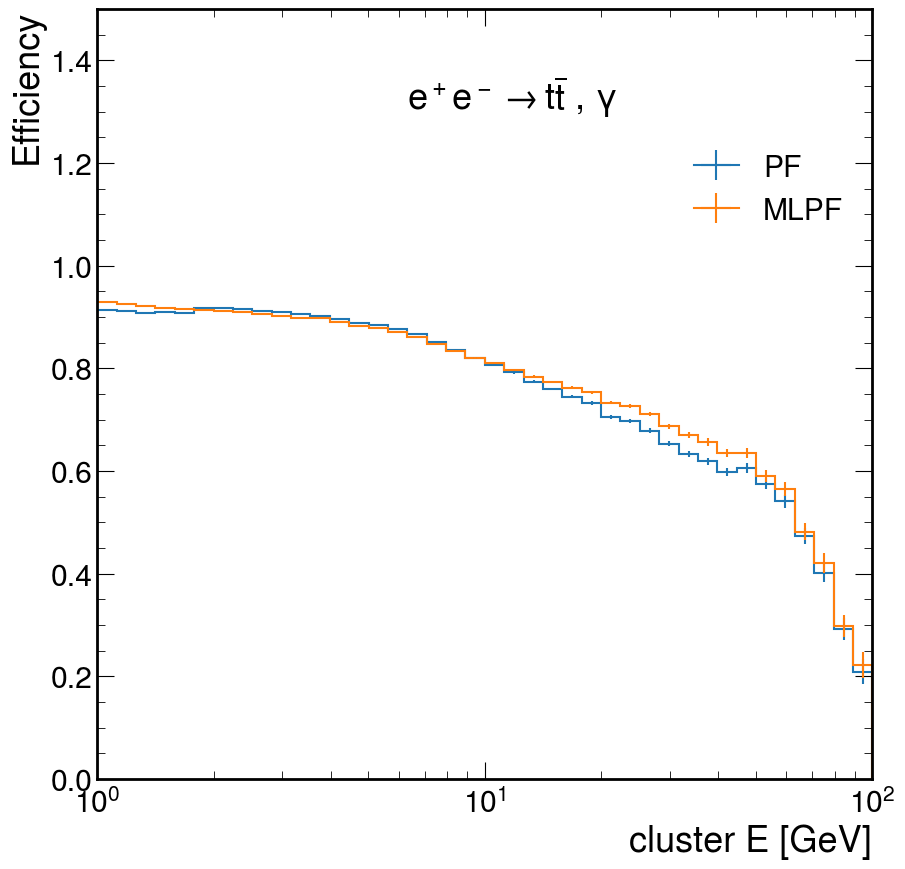

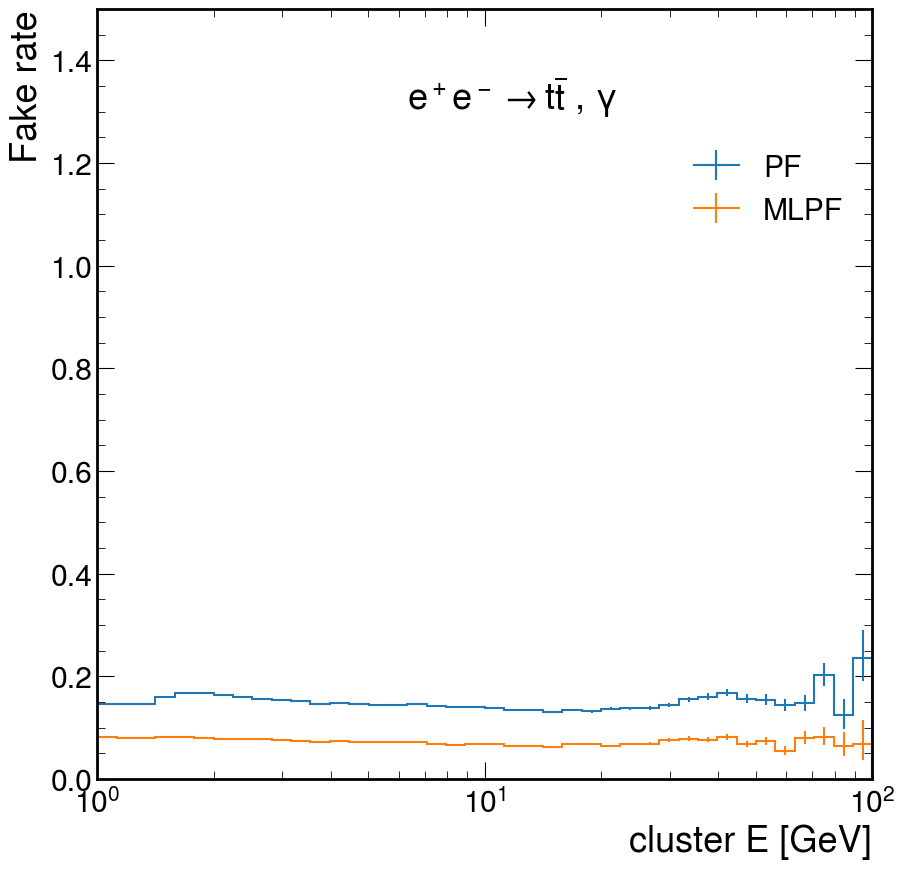

In [20]:
var = 5
log_ = True

if log_:
    bins = np.logspace(0, 2, 41)
else:
    bins = np.linspace(1, 100, 41)

plot_eff_and_fake_rate(icls=pid, ivar=var, ielem=ielem, bins=bins,
                       log=True, 
                       physics_process_lab=physics_process[sample],
                       textx=0.4,
                       texty=0.87,
                      )

# Distributions

In [692]:
yvals, X, _ = load_eval_data(path, max_files=50)

path evaluation/epoch_96/clic_edm_ttbar_pf/test/*.parquet
['evaluation/epoch_96/clic_edm_ttbar_pf/test/pred_batch3708.parquet', 'evaluation/epoch_96/clic_edm_ttbar_pf/test/pred_batch2202.parquet', 'evaluation/epoch_96/clic_edm_ttbar_pf/test/pred_batch175.parquet', 'evaluation/epoch_96/clic_edm_ttbar_pf/test/pred_batch1168.parquet', 'evaluation/epoch_96/clic_edm_ttbar_pf/test/pred_batch3670.parquet', 'evaluation/epoch_96/clic_edm_ttbar_pf/test/pred_batch994.parquet', 'evaluation/epoch_96/clic_edm_ttbar_pf/test/pred_batch1989.parquet', 'evaluation/epoch_96/clic_edm_ttbar_pf/test/pred_batch1010.parquet', 'evaluation/epoch_96/clic_edm_ttbar_pf/test/pred_batch165.parquet', 'evaluation/epoch_96/clic_edm_ttbar_pf/test/pred_batch1178.parquet', 'evaluation/epoch_96/clic_edm_ttbar_pf/test/pred_batch3718.parquet', 'evaluation/epoch_96/clic_edm_ttbar_pf/test/pred_batch2212.parquet', 'evaluation/epoch_96/clic_edm_ttbar_pf/test/pred_batch1000.parquet', 'evaluation/epoch_96/clic_edm_ttbar_pf/test/pre

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 19.47it/s]


In [1245]:
def reso_plot(pid, var, bins, physics_process_lab="", textx=0.01, texty=0.87):

    fig = plt.figure()
    ax = plt.axes()

    msk = (yvals["gen_cls_id"] == pid) & (yvals["cand_cls_id"] != 0)
    
    vals_gen = awkward.flatten(yvals["gen_" + var][msk])
    vals_cand = awkward.flatten(yvals["cand_" + var][msk])
    reso_1 = vals_cand / vals_gen
    
    msk = (yvals["gen_cls_id"] == pid) & (yvals["pred_cls_id"] != 0)
    
    vals_gen = awkward.flatten(yvals["gen_" + var][msk])
    vals_mlpf = awkward.flatten(yvals["pred_" + var][msk])
    reso_2 = vals_mlpf / vals_gen
    
    plt.hist(reso_1, bins=bins, histtype="step", lw=2, label="PF, M={:.2f}, IQR={:.2f}".format(*med_iqr(reso_1)))
    plt.hist(reso_2, bins=bins, histtype="step", lw=2, label="MLPF, M={:.2f}, IQR={:.2f}".format(*med_iqr(reso_2)))
    plt.yscale("log")
    if var == "pt":
        plt.xlabel(r"$p_\mathrm{T,reco} / p_\mathrm{T,gen}$")
    elif var == "eta":
        plt.xlabel(r"$\eta_\mathrm{reco} / \eta_\mathrm{gen}$")
    elif var == "energy":
        plt.xlabel(r"$E_\mathrm{reco} / E_\mathrm{gen}$")        
        
    plt.ylabel("Number of particles / bin")
    
    text = physics_process_lab + " , " + CLASS_NAMES_CLIC[pid]
    plt.text(textx, texty, text, ha="left", transform=ax.transAxes)
    plt.xlim(min(bins), max(bins))
    plt.legend(loc=(0.4, 0.7))
    # plt.ylim(1, 1e9)
    # plt.savefig("{}/pt_res_ch_had.pdf".format(outpath), bbox_inches="tight")
    plt.savefig(f"{outpath}/res_{var}_{pid}.pdf", bbox_inches="tight")

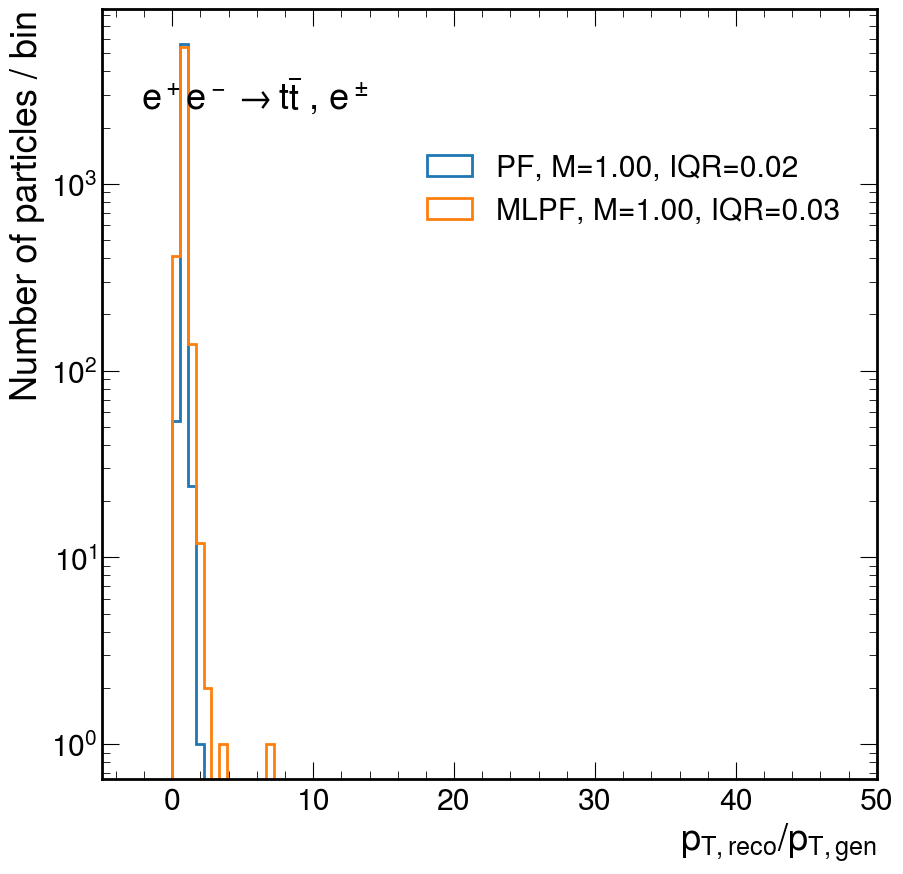

In [1247]:
pid = 4
var = "pt"
bins = np.linspace(-5,50,100)

reso_plot(pid=pid, var=var, bins=bins, physics_process_lab=physics_process[sample], textx=0.05, texty=0.87)

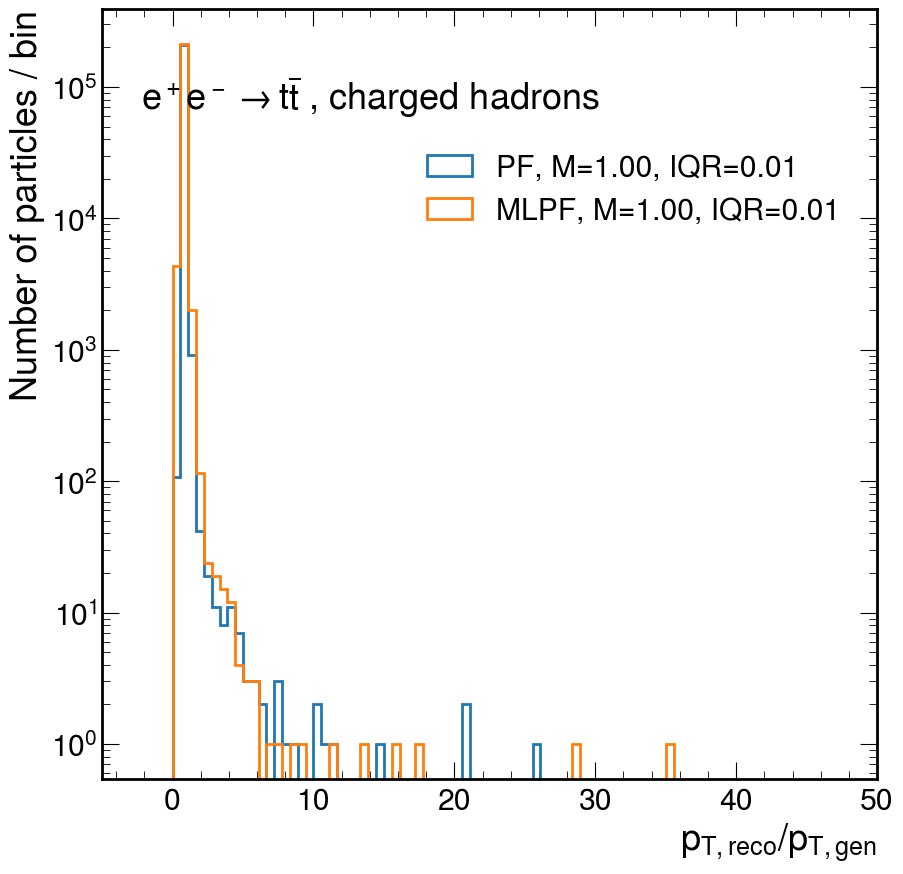

In [1248]:
pid = 1
var = "pt"
bins = np.linspace(-5,50,100)

reso_plot(pid=pid, var=var, bins=bins, physics_process_lab=physics_process[sample], textx=0.05, texty=0.87)

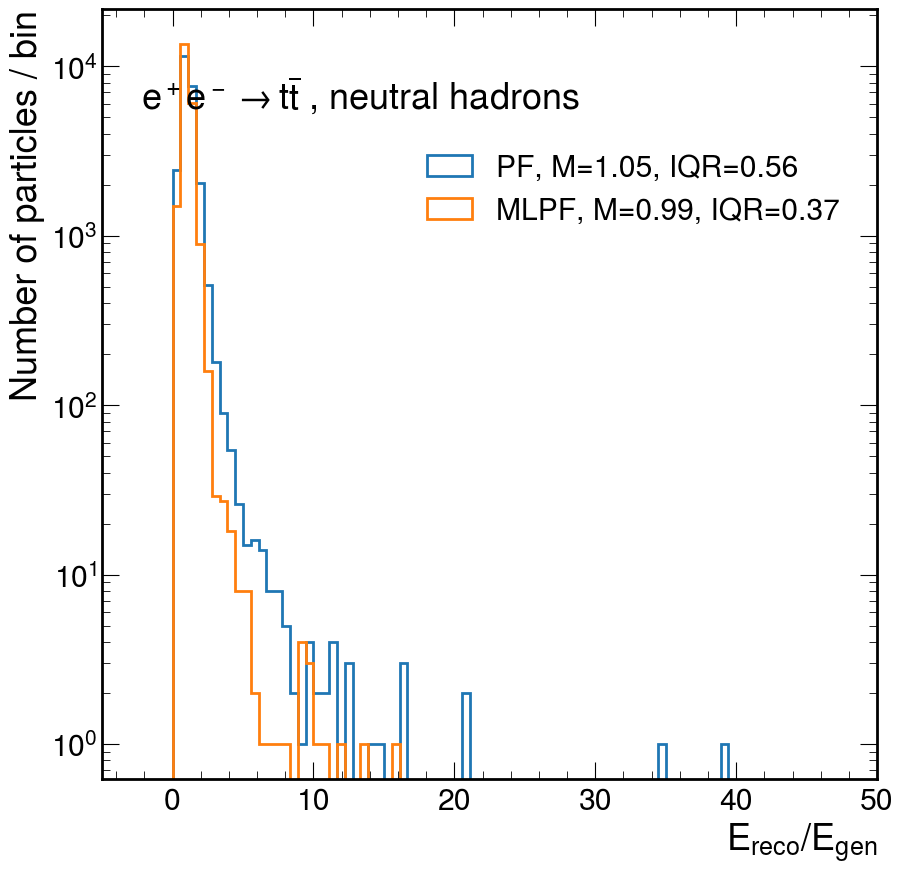

In [1249]:
pid = 2
var = "energy"
bins = np.linspace(-5,50,100)

reso_plot(pid=pid, var=var, bins=bins, physics_process_lab=physics_process[sample], textx=0.05, texty=0.87)

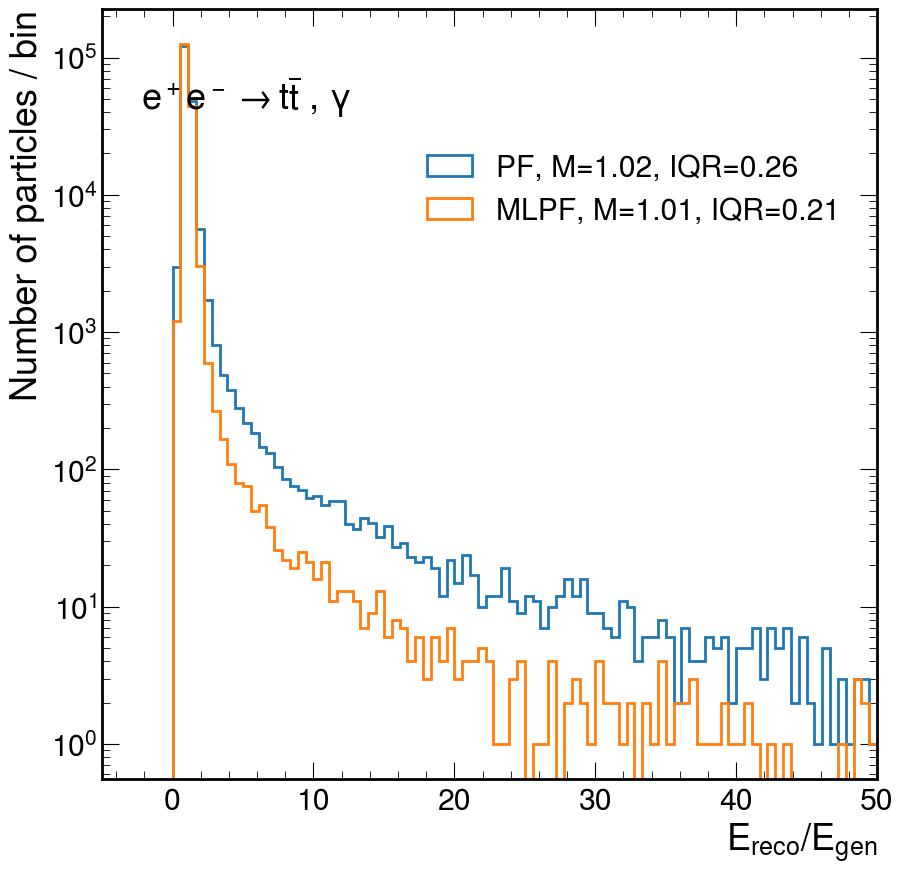

In [1250]:
pid = 3
var = "energy"
bins = np.linspace(-5,50,100)

reso_plot(pid=pid, var=var, bins=bins, physics_process_lab=physics_process[sample], textx=0.05, texty=0.87)

# Lepton Isolation resolution plots

In [1257]:
def reso_plot_isolated(pid, var, bins, physics_process_lab="", textx=0.01, texty=0.87, apply_isolation="Isolated"):

    fig = plt.figure()
    ax = plt.axes()

#     msk = (yvals["gen_cls_id"] == pid) & (yvals["cand_cls_id"] != 0) & (yvals["pred_cls_id"] != 0)
#     vals_gen = awkward.flatten(yvals["gen_" + var][msk])
#     vals_cand = awkward.flatten(yvals["cand_" + var][msk])
#     vals_mlpf = awkward.flatten(yvals["pred_" + var][msk])
#     reso_1 = vals_cand / vals_gen
#     reso_2 = vals_mlpf / vals_gen

    msk = (yvals["gen_cls_id"] == pid) & (yvals["cand_cls_id"] != 0)
    
    if apply_isolation == "Isolated":
        msk_iso = get_isolation(msk)<0.15
    else:
        msk_iso = get_isolation(msk)>0.15
    
    vals_gen = awkward.flatten(yvals["gen_" + var][msk][msk_iso])
    vals_cand = awkward.flatten(yvals["cand_" + var][msk][msk_iso])
    reso_1 = vals_cand / vals_gen
    
    msk = (yvals["gen_cls_id"] == pid) & (yvals["pred_cls_id"] != 0)
    
    if apply_isolation == "Isolated":
        msk_iso = get_isolation(msk)<0.15
    else:
        msk_iso = get_isolation(msk)>0.15
    
    vals_gen = awkward.flatten(yvals["gen_" + var][msk][msk_iso])
    vals_mlpf = awkward.flatten(yvals["pred_" + var][msk][msk_iso])
    reso_2 = vals_mlpf / vals_gen
    
    plt.hist(reso_1, bins=bins, histtype="step", lw=2, label="PF, M={:.2f}, IQR={:.2f}".format(*med_iqr(reso_1)))
    plt.hist(reso_2, bins=bins, histtype="step", lw=2, label="MLPF, M={:.2f}, IQR={:.2f}".format(*med_iqr(reso_2)))
    plt.yscale("log")
    if var == "pt":
        plt.xlabel(r"$p_\mathrm{T,reco} / p_\mathrm{T,gen}$")
    elif var == "eta":
        plt.xlabel(r"$\eta_\mathrm{reco} / \eta_\mathrm{gen}$")
    elif var == "energy":
        plt.xlabel(r"$E_\mathrm{reco} / E_\mathrm{gen}$")        
        
    plt.ylabel("Number of particles / bin")
    
    text = physics_process_lab + " , " + apply_isolation + " " + CLASS_NAMES_CLIC[pid]
    plt.text(textx, texty, text, ha="left", transform=ax.transAxes)
    plt.xlim(min(bins), max(bins))
    plt.legend(loc=(0.4, 0.7))
    # plt.ylim(1, 1e9)
    # plt.savefig("{}/pt_res_ch_had.pdf".format(outpath), bbox_inches="tight")
    plt.savefig(f"{outpath}/{apply_isolation}_res_{var}_{pid}.pdf", bbox_inches="tight")

In [1266]:
yvals, X, _ = load_eval_data(path, max_files=2)

path evaluation/epoch_96/clic_edm_ttbar_pf/test/*.parquet
['evaluation/epoch_96/clic_edm_ttbar_pf/test/pred_batch3708.parquet', 'evaluation/epoch_96/clic_edm_ttbar_pf/test/pred_batch2202.parquet', 'evaluation/epoch_96/clic_edm_ttbar_pf/test/pred_batch175.parquet', 'evaluation/epoch_96/clic_edm_ttbar_pf/test/pred_batch1168.parquet', 'evaluation/epoch_96/clic_edm_ttbar_pf/test/pred_batch3670.parquet', 'evaluation/epoch_96/clic_edm_ttbar_pf/test/pred_batch994.parquet', 'evaluation/epoch_96/clic_edm_ttbar_pf/test/pred_batch1989.parquet', 'evaluation/epoch_96/clic_edm_ttbar_pf/test/pred_batch1010.parquet', 'evaluation/epoch_96/clic_edm_ttbar_pf/test/pred_batch165.parquet', 'evaluation/epoch_96/clic_edm_ttbar_pf/test/pred_batch1178.parquet', 'evaluation/epoch_96/clic_edm_ttbar_pf/test/pred_batch3718.parquet', 'evaluation/epoch_96/clic_edm_ttbar_pf/test/pred_batch2212.parquet', 'evaluation/epoch_96/clic_edm_ttbar_pf/test/pred_batch1000.parquet', 'evaluation/epoch_96/clic_edm_ttbar_pf/test/pre

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.35it/s]


IndexError: cannot do a non-empty take from an empty axes.

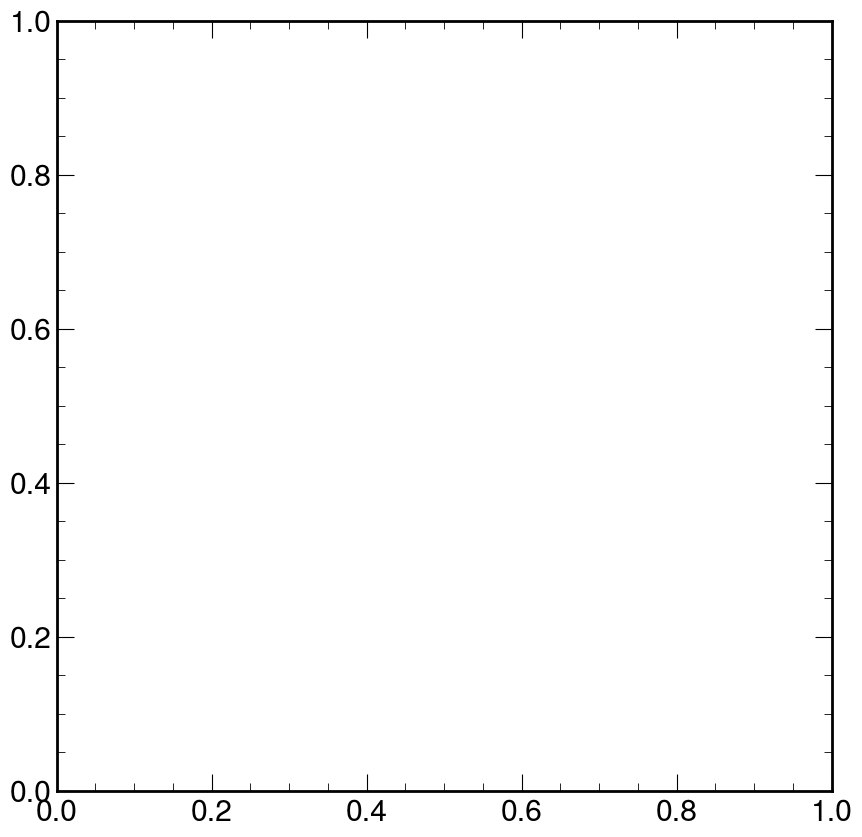

In [1269]:
pid = 2
var = "energy"
bins = np.linspace(-5,30,100)

reso_plot_isolated(pid=pid, var=var, bins=bins, physics_process_lab=physics_process[sample], 
                   textx=0.05, 
                   texty=0.87,
                   apply_isolation="Isolated"
                  )

# Isolation for different samples

In [1291]:
isolation = {}
isolation["electrons"] = {}
isolation["muons"] = {}

In [1297]:
# sample = "clic_edm_ttbar_pf"
sample = "clic_edm_qq_pf"

PATH = "evaluation/epoch_96"

pred_path = Path(f"{PATH}/{sample}/test/")
path = str(pred_path / "*.parquet")

outpath = f"paper_plots/{sample}"   # plots path
os.system(f"mkdir -p {outpath}");

In [1298]:
yvals, X, _ = load_eval_data(path, max_files=50)

path evaluation/epoch_96/clic_edm_qq_pf/test/*.parquet
['evaluation/epoch_96/clic_edm_qq_pf/test/pred_batch7424.parquet', 'evaluation/epoch_96/clic_edm_qq_pf/test/pred_batch3708.parquet', 'evaluation/epoch_96/clic_edm_qq_pf/test/pred_batch2202.parquet', 'evaluation/epoch_96/clic_edm_qq_pf/test/pred_batch175.parquet', 'evaluation/epoch_96/clic_edm_qq_pf/test/pred_batch1168.parquet', 'evaluation/epoch_96/clic_edm_qq_pf/test/pred_batch5244.parquet', 'evaluation/epoch_96/clic_edm_qq_pf/test/pred_batch3670.parquet', 'evaluation/epoch_96/clic_edm_qq_pf/test/pred_batch994.parquet', 'evaluation/epoch_96/clic_edm_qq_pf/test/pred_batch6056.parquet', 'evaluation/epoch_96/clic_edm_qq_pf/test/pred_batch1989.parquet', 'evaluation/epoch_96/clic_edm_qq_pf/test/pred_batch4636.parquet', 'evaluation/epoch_96/clic_edm_qq_pf/test/pred_batch1010.parquet', 'evaluation/epoch_96/clic_edm_qq_pf/test/pred_batch165.parquet', 'evaluation/epoch_96/clic_edm_qq_pf/test/pred_batch5254.parquet', 'evaluation/epoch_96/cl

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 16.06it/s]


In [1299]:
isolation["electrons"][sample] = get_isolation(msk=yvals["gen_cls_id"]==4)

In [1300]:
isolation["muons"][sample] = get_isolation(msk=yvals["gen_cls_id"]==5)

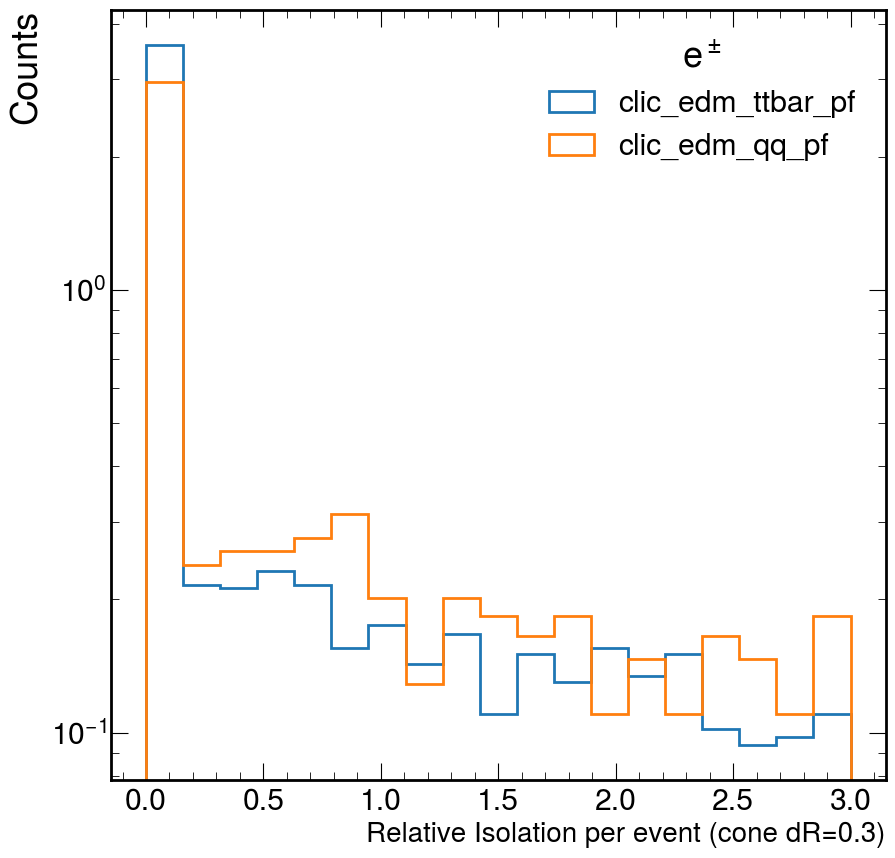

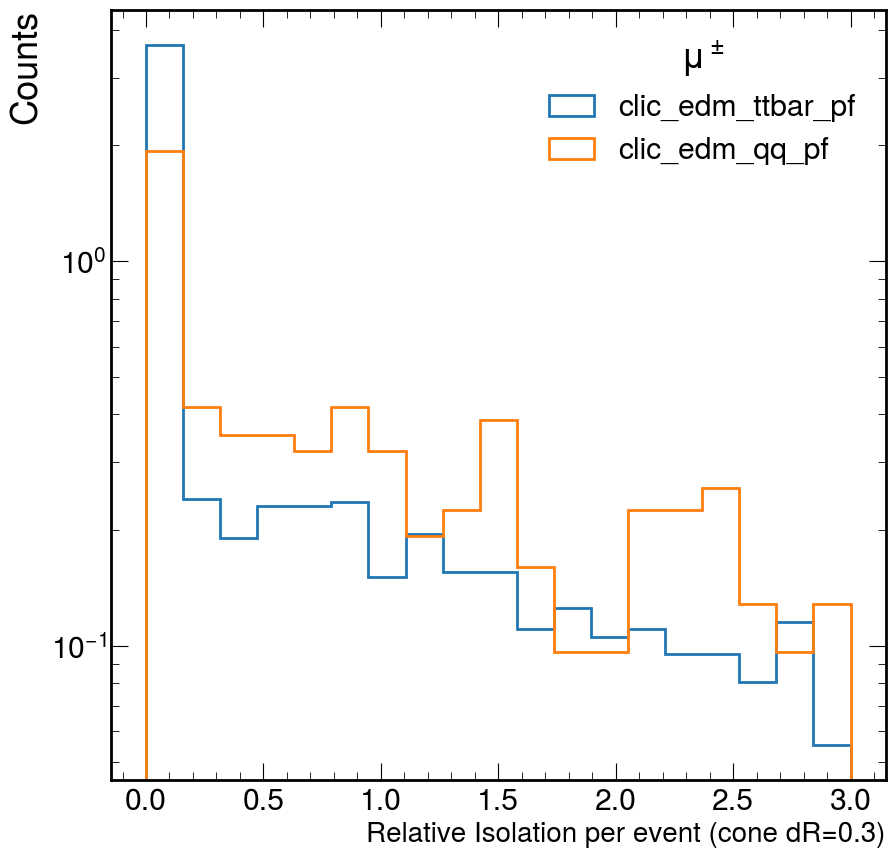

In [1321]:
for lepton in isolation:
    fig, ax = plt.subplots()
    
    for sample in isolation[lepton]:
        ax.hist(ak.flatten(isolation[lepton][sample]), 
                bins=np.linspace(0,3,20), 
                histtype="step", 
                lw=2, 
                label=sample,
                density=True,
               )
        
    if lepton == "electrons":
        title = r"$e^\pm$"
    elif lepton == "muons":
        title = r"$\mu^\pm$"
        
    ax.legend(title=title)
    ax.set_yscale("log")
    
    ax.set_xlabel('Relative Isolation per event (cone dR=0.3)', fontsize=20)
    ax.set_ylabel('Counts')
    
    plt.savefig(f"isolation_{lepton}.pdf")